In [101]:

!pip install m2cgen


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Principal Notebook. Trata o dataset inteiro

In [102]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

Utils

In [103]:
def cross_val(regressor, X, y, k=10):
    s = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
    results = cross_validate(regressor, X, y, cv=k, scoring=s)
    print(pd.DataFrame(results).mean())


def plot_results(regressor, X_train, y_train, X_test, y_test, y):
    model = regressor.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    errors = np.abs(y_pred - y_test)
    errors = errors / max(errors)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, s=200 * errors, c=errors, alpha=0.7, marker='x')
    plt.ylim(0, max(y_pred.max(), y_test.max()))
    plt.xlim(0, max(y_pred.max(), y_test.max()))
    plt.xlabel('Value')
    plt.ylabel('Predicted')

    plt.plot([0, max(y)], [0, max(y)], c='gray')


def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                if (corr_matrix.columns[i] not in col_corr) and (corr_matrix.index.tolist()[j] not in col_corr):
                    col_name = corr_matrix.columns[i]
                    col_corr.add(col_name)
    return col_corr

Prepara dataset e remove features

In [104]:
df = pd.read_csv("../dataset/dataset.csv")

# sequencias do dataset de teste final
seq_test = [
    'BQSquare_416x240_60',
    'Flowervase_416x240_30',
    'tempete_cif',
    'waterfall_cif',
    'PartyScene_832x480_50',
    'aspen_480p_30f',
    'aspen_1080p',
    'into_tree_480p_30f',
    'in_to_tree_420_720p50',
    'in_to_tree_1080p50',
    'station2_480p25',
    'blue_sky_1080p25',
    'Netflix_DrivingPOV_1280x720_60fps_8bit_420_120f',
    'mobcal_720p_30f',
    'station2_1080p25'
]

# sequencias que não devem ser usadas
seq_drop = [
    'crowd_run_1080p50'  # duplicada
]

df.drop([
    'cur_ref_count',
    'cur_showable_frame',
    'ref_showable_frame',
    'downsample_level',
    'num_refinements',
    'bit_depth',
    # 'selected'
    # 'ref_frame_error'
    # 'inliers_rate',
    'fast_error',
    'warp_error'
], axis=1, inplace=True)

data_test = df[df.name.isin(seq_test)].copy()
data_train = df[~df.name.isin(seq_test)].copy()

data_train

,name,distance,num_ref_frames,cq_level,cur_order_hint,ref_ref_count,ref_order_hint,src_width,src_height,src_stride,...,params_4,params_5,alpha,beta,gamma,delta,seg_count,ref_frame_error,selected,inliers_rate
0,720p50_parkrun_ter,1,3,80,3,7,0,1280,720,1600,...,0.001133,1.000836,64.0,-64.0,64.0,64.0,282,13583723,1,0.789596
1,720p50_parkrun_ter,1,1,80,2,5,0,1280,720,1600,...,0.000509,1.000198,0.0,-64.0,64.0,0.0,312,12353545,1,0.995848
2,720p50_parkrun_ter,1,1,80,4,2,12,1280,720,1600,...,-0.000414,0.999844,0.0,0.0,0.0,0.0,340,13120077,1,0.993794
3,720p50_parkrun_ter,1,2,80,4,2,2,1280,720,1600,...,0.000859,1.000341,0.0,-64.0,64.0,0.0,331,15298827,1,0.962245
4,720p50_parkrun_ter,1,1,80,5,2,12,1280,720,1600,...,-0.000308,0.999848,0.0,0.0,0.0,0.0,335,13184703,1,0.996654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22623,YachtRide_1920x1080_120fps_420_8bit_YUV,1,1,220,26,2,16,1920,1080,2240,...,-0.000620,0.997788,-128.0,64.0,-64.0,-128.0,138,1718698,0,0.270499
22624,YachtRide_1920x1080_120fps_420_8bit_YUV,1,1,220,26,2,24,1920,1080,2240,...,0.000868,1.000068,0.0,-64.0,64.0,0.0,165,1986437,0,0.320349
22625,YachtRide_1920x1080_120fps_420_8bit_YUV,1,1,220,28,2,16,1920,1080,2240,...,-0.000679,0.998326,-128.0,64.0,-64.0,-128.0,157,1716537,0,0.308999
22626,YachtRide_1920x1080_120fps_420_8bit_YUV,1,1,220,28,2,26,1920,1080,2240,...,0.000719,1.001514,128.0,-64.0,64.0,128.0,166,1772204,0,0.344306


Info de balanceamento

selected
1    10512
0     8657
Name: count, dtype: int64

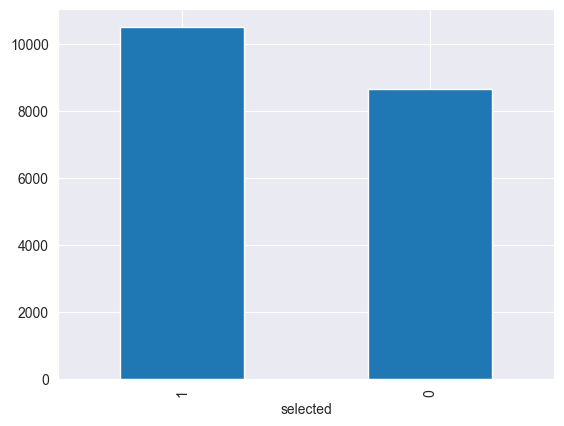

In [105]:
data_train['selected'].value_counts().plot(kind='bar')
data_train['selected'].value_counts()

Separa os dados em treino e teste

In [106]:
X = data_train.drop(['selected'], axis=1)
y = data_train['selected']

Correlação das features

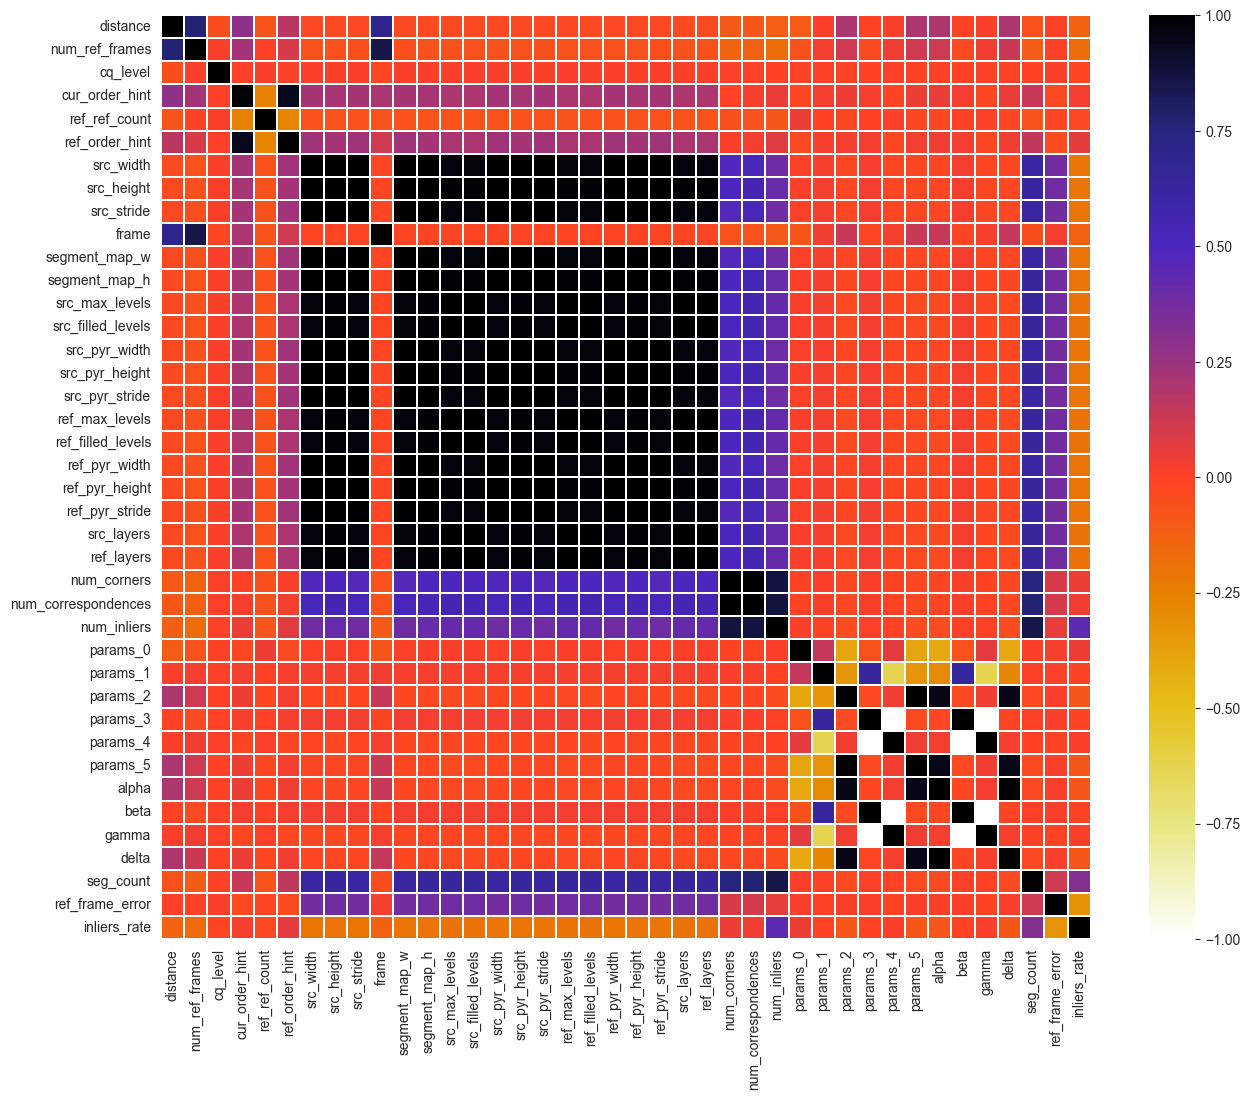

In [108]:
plt.figure(figsize=(15, 12))
sns.heatmap(X.drop('name', axis=1).corr(), cmap=plt.cm.CMRmap_r, linewidths=.1)
plt.show()

Features correlacionadas em mais de 90%

In [109]:
corr_features = correlation(X.drop('name', axis=1), 0.8)
corr_features = corr_features.difference(['fast_error', 'ref_frame_error'])

X = X.drop(corr_features, axis=1)

corr_features

{'alpha',
 'beta',
 'delta',
 'frame',
 'gamma',
 'num_correspondences',
 'num_inliers',
 'params_4',
 'params_5',
 'ref_filled_levels',
 'ref_layers',
 'ref_max_levels',
 'ref_order_hint',
 'ref_pyr_height',
 'ref_pyr_stride',
 'ref_pyr_width',
 'segment_map_h',
 'segment_map_w',
 'src_filled_levels',
 'src_height',
 'src_layers',
 'src_max_levels',
 'src_pyr_height',
 'src_pyr_stride',
 'src_pyr_width',
 'src_stride'}

Correlação após remoção das features

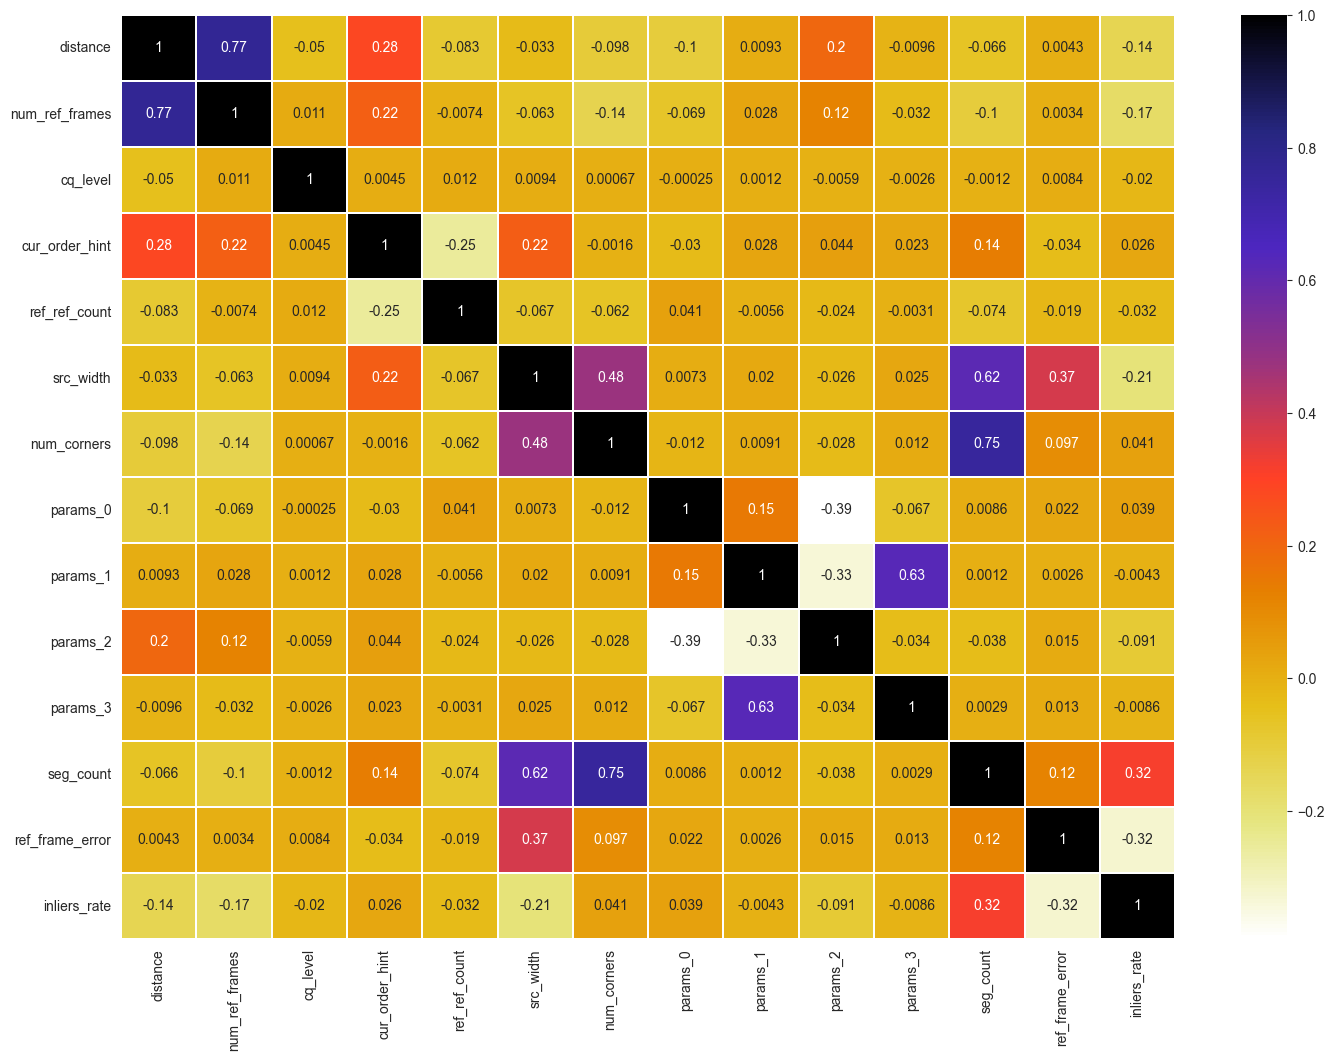

In [110]:
plt.figure(figsize=(17, 12))
sns.heatmap(X.drop('name', axis=1).corr(), cmap=plt.cm.CMRmap_r, annot=True, linewidths=.1)
plt.show()

Info sobre features mais relevantes

<Axes: >

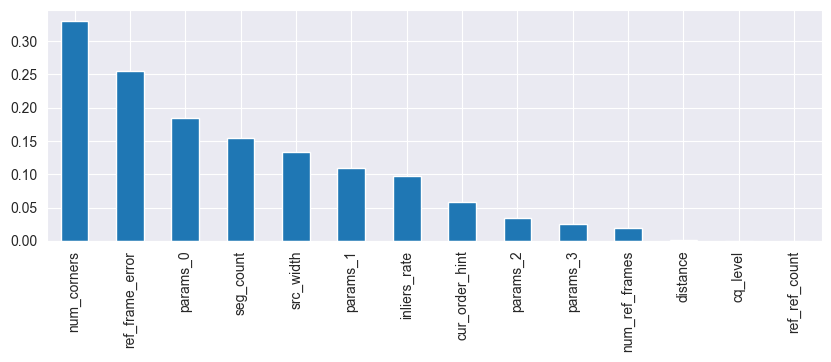

In [111]:
mutual_info = mutual_info_regression(X.drop('name', axis=1), y)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.drop('name', axis=1).columns
mutual_info.sort_values(ascending=False).plot.bar(figsize=(10, 3))

Lista de features mais importantes baseadas no 1/4-percentil

In [112]:
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=50)
selected_top_columns.fit(X.drop('name', axis=1), y)

select_features = X.drop('name', axis=1).columns[selected_top_columns.get_support()]

select_features

Index(['src_width', 'num_corners', 'params_0', 'params_1', 'seg_count',
       'ref_frame_error', 'inliers_rate'],
      dtype='object')

K-Folds

In [113]:
def kfold(model, k_df, k, balance=False, normalize=False):
    seq_names = k_df['name'].drop_duplicates()

    size_slice = math.floor(len(seq_names) / k)

    ret = []

    for i in range(k):
        i1 = i * size_slice
        i2 = (i + 1) * size_slice
        seq_test = seq_names[i1: i2]
        seq_train = pd.concat([seq_names[i2:], seq_names[0: i1]])

        df_k_test = k_df[k_df.name.isin(seq_test)]
        df_k_train = k_df[k_df.name.isin(seq_train)]

        df_k_X_test = df_k_test.drop(['name', 'selected'], axis=1)
        df_k_y_test = df_k_test['selected']
        df_k_X_train = df_k_train.drop(['name', 'selected'], axis=1)
        df_k_y_train = df_k_train['selected']

        df_k_X_test = df_k_X_test[select_features]
        df_k_X_train = df_k_X_train[select_features]

        if balance:
            smote = SMOTE(random_state=42)
            df_k_X_train, df_k_y_train = smote.fit_resample(df_k_X_train, df_k_y_train)

        if normalize:
            scaler = StandardScaler().fit(df_k_X_train)
            df_k_X_train = scaler.transform(df_k_X_train)
            df_k_X_test = scaler.transform(df_k_X_test)

        model.fit(df_k_X_train, df_k_y_train)
        df_k_y_pred = model.predict(df_k_X_test)

        ret.append(classification_report(df_k_y_test, df_k_y_pred))

    return ret

In [123]:
dtc = tree.DecisionTreeClassifier(max_depth=len(select_features))

results = kfold(dtc, data_train, 10)
i = 1

for result in results:
    print('-------------------------', i, '-------------------------')
    print(result)
    i += 1

------------------------- 1 -------------------------
              precision    recall  f1-score   support

           0       0.85      0.97      0.90       469
           1       0.98      0.90      0.93       794

    accuracy                           0.92      1263
   macro avg       0.91      0.93      0.92      1263
weighted avg       0.93      0.92      0.92      1263

------------------------- 2 -------------------------
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       668
           1       0.94      0.91      0.93       804

    accuracy                           0.92      1472
   macro avg       0.92      0.92      0.92      1472
weighted avg       0.92      0.92      0.92      1472

------------------------- 3 -------------------------
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       909
           1       0.88      0.83      0.85       596

    accuracy        

In [124]:
dtc = tree.DecisionTreeClassifier(max_depth=len(select_features))

results = kfold(dtc, data_train, 10, balance=True, normalize=True)
i = 1

for result in results:
    print('-------------------------', i, '-------------------------')
    print(result)
    i += 1

------------------------- 1 -------------------------
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       469
           1       0.98      0.91      0.95       794

    accuracy                           0.93      1263
   macro avg       0.92      0.94      0.93      1263
weighted avg       0.94      0.93      0.93      1263

------------------------- 2 -------------------------
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       668
           1       0.91      0.99      0.95       804

    accuracy                           0.94      1472
   macro avg       0.95      0.93      0.94      1472
weighted avg       0.94      0.94      0.94      1472

------------------------- 3 -------------------------
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       909
           1       0.86      0.84      0.85       596

    accuracy        